# Running and Checking GMF deflections

Notebook version of `run_gmf_deflections.py`. Used as a test suite for the same python file. Also contains plots to check if we get the right coordinates correct.

In [27]:
import os
import pickle
import sys

import numpy as np
from scipy.optimize import root
from fancy import Data
from fancy.plotting import AllSkyMap

import crpropa

In [28]:
known_ptypes = {
    "p": (1, 1),
    "He": (4, 2),
    "C": (12, 6),
    "N": (14, 7),
    "O": (16, 8),
    "Na": (24, 12),
    "Si": (28, 14),
    "Fe": (56, 26),
}


In [29]:
"""Setting up"""
# Define file containing source catalogue information
uhecr_file = "../../data/UHECRdata.h5"

detector_type = "TA2015"
assert detector_type in ["auger2010", "auger2014", "TA2015"]

# UHECR mass
ptype = "p"
assert ptype in known_ptypes

# GMF model
gmf = "JF12"
assert gmf in ["JF12", "PT11", "TF17"]

# # set random seed
random_seed = 199903

print("Configuration: ", detector_type, ptype, gmf, random_seed)

"""set detector and detector properties"""
if detector_type == "TA2015":
    from fancy.detector.TA2015 import Eth, M, alpha_T, detector_properties
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import Eth, M, alpha_T, detector_properties
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import Eth, M, alpha_T, detector_properties
else:
    raise Exception("Unknown detector type!")

# define output file
output_file = "../output/" + f"defl_{detector_type}_{gmf}_{ptype}_{random_seed}.pkl"

# construct Dataset
data = Data()
data.add_uhecr(uhecr_file, detector_type, ptype=ptype)
data.add_detector(detector_properties)

# get uhecr detected arrival direction and detected energy
uhecr_coord = data.uhecr.coord
uhecr_energy = data.uhecr.energy

Configuration:  TA2015 p JF12 199903


In [30]:
# get lon and lat arrays for future reference
# shift lons by 180. due to how its defined in mpl
uhecr_lons = np.pi - uhecr_coord.galactic.l.rad
uhecr_lats = uhecr_coord.galactic.b.rad

# true UHECRs as reported on paper
omega_true = np.zeros((len(uhecr_lons), 2))
omega_true[:, 0] = np.pi - uhecr_lons
omega_true[:, 1] = uhecr_lats

The below skymap compares how `omega_true` is defined compared to `uhecr_coord` and `uhecr_lons / lats`. 

`omega_true` and `uhecr_coord` match, and they both match with the UHECRs shown in `plot_galactic_coords.ipynb`, so we stick with this one, define `omega_true = uhecr_coord.galactic` and remove the definition of `uhecr_lons / lats` as its not used anywhere else. This is the case as previously, the skymap was defined from -180 to 180, but now its defined from 0 to 360.

The correctness of the placement of the UHECRs have been verified with [Search for correlations between arrival directions of IceCube neutrino events and ...](https://iopscience.iop.org/article/10.1088/1475-7516/2016/01/037) (Figure 7).

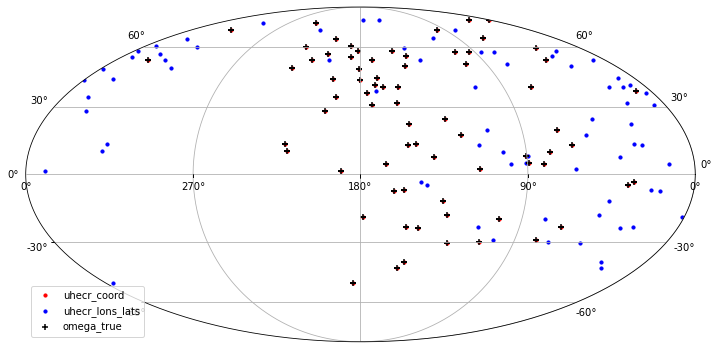

In [31]:
# plot omega_true (the UHECRs reported in dataset) on skymap
skymap = AllSkyMap(lon_0=180)
skymap.ax.grid()

# from SkyCoord, given as uhecr_coord
skymap.scatter(np.rad2deg(uhecr_coord.galactic.l.rad), np.rad2deg(uhecr_coord.galactic.b.rad),
                color="r", marker="o", alpha=1, s=10.0, label="uhecr_coord")

# transforming longitude of uhecr_coord by pi (uhecr_lons = pi - uhecr_coord.galactic.l.rad)
skymap.scatter(np.rad2deg(uhecr_lons), np.rad2deg(uhecr_lats),
                color="b", marker="o", alpha=1, s=10.0, label="uhecr_lons_lats")

# omega true, transforming uhecr_lons by 180 again (omega_true = pi - uhecr_lons)
skymap.scatter(np.rad2deg(omega_true[:, 0]), np.rad2deg(omega_true[:, 1]),
                color="k", marker="+", alpha=1, s=40.0, label="omega_true")

skymap.ax.legend()

In [32]:
# number of uhecrs in the sample
N_uhecr = len(uhecr_coord)

# also get reconstruction uncertainties
arr_dir_unc = np.deg2rad(data.detector.coord_uncertainty)

Below we convert from SkyCoord (astropy) to Vector3D (CRPropa).

#### Things to note about this conversion

**SkyCoord** defines galactic longitude and latitude as such:
- longitude [0, 2pi], latitude [-pi/2, pi/2] (checked manually)

Furthermore, the following excerpt from [Galactic Coordinate system definition](https://docs.astropy.org/en/stable/api/astropy.coordinates.Galactic.html#astropy.coordinates.Galactic) shows how the galactic coordinates are defined:


   "This frame is used in a variety of Galactic contexts because it has as its x-y plane the plane of the Milky Way. 
   The positive x direction (i.e., the l=0, b=0 direction) points to the center of the Milky Way and the z-axis points 
   toward the North Galactic Pole (following the IAU’s 1958 definition [1]). However, unlike the Galactocentric frame, 
   the origin of this frame in 3D space is the solar system barycenter, not the center of the Milky Way." 

i.e. 
- the galactic coordinates are solar system barycentric (origin at barycenter)
- x-coordinate points towards center of milky way
- z-coordinate points towards galactic north

**Vector3D** defines galactic coordinates in the following manner:
- galactic center at the origin (galactocentric)
- x-coordinates points away from Sun
- z-coordinate points towards galactic north

The above ensures that, as we dont care about distances, we can interchangeably use galactocentric and solar system barycentric coordinates without any worry.

- lon: [-pi, pi], lat: [0, pi] (defined from [Vector3D.h](https://github.com/CRPropa/CRPropa3/blob/master/include/crpropa/Vector3.h))

#### Summary
- no need to worry about galactocentric and solar system barycentric
- shift latitude *by* pi/2: `vector3d_lat = pi/2 - skycoord_lat`
- shift longitude *from* pi: `vector3d_lon = skycoord_lon - pi`
- when plotting, **shift everything back**


In [33]:
# convert SkyCoord -> crpropa.Vector3d() to use with CRPropa
# coord is in galactic frame, lon and lat
# Angle definitions:
# CRPropa uses (copied from Vector3.h & JF12Field.h (defined same in all MagneticField classes))
#   longitude (phi) [-pi, pi] 
#   colatitude (theta) [0, pi] 
# SkyCoord uses:
#   lon: [0, 2pi]
#   lat: [-pi/2, pi/2]
# Skymap uses same as SkyCoord:
#    lon: [0,2pi]
#    lat: [-pi/2, pi/2]

# KW 14.08: Verified and checked that the coordinate transf. are properly performed

uhecr_vector3d = []
for i, coord in enumerate(uhecr_coord):
    v = crpropa.Vector3d()
    v.setRThetaPhi(1, np.pi / 2.0 - coord.galactic.b.rad, coord.galactic.l.rad - np.pi)
    uhecr_vector3d.append(v)

Below checks how the Vector3d object is implemented. 

- *uhecr_vector3d, no transf.* :  coordinates when transforming back directly from `uhecr_vector3d` (where we set Theta = pi/2 - coord.galactic.b.rad)
- *uhecr_vector3d, transf.*: `uhecr_vector3d`, but shifting the pi/2 in latitude and subtracting **by** pi initially
- *omega_true* : as before

*omega_true* and *uhecr_vector3d, transf.* shows the same plot, so they must be the same. Thus:
- shift lon by pi: `vector3d_lon = skycoord_lon - pi`
- shift lat by pi/2: `vector3d_lat = pi/2 - skycoord_lat`

To plot it, we just shift everything back.

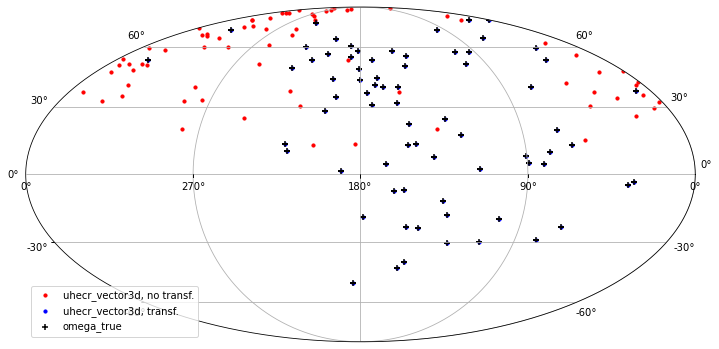

In [34]:
# check if this is properly plotted
# plot omega_true (the UHECRs reported in dataset) on skymap
skymap = AllSkyMap(lon_0=180)
skymap.ax.grid()

# original vector3d coordinates when transforming back 
skymap.scatter([np.rad2deg(v.getPhi()) for v in uhecr_vector3d], 
                [np.rad2deg(v.getTheta()) for v in uhecr_vector3d],
                color="r", marker="o", alpha=1, s=10.0, label="uhecr_vector3d, no transf.")

# transforming back from Vector3d theta to mpl lat by subtracting by pi/2
skymap.scatter([np.rad2deg(v.getPhi() - np.pi) for v in uhecr_vector3d], 
                [np.rad2deg(np.pi/2 - v.getTheta()) for v in uhecr_vector3d],
                color="b", marker="o", alpha=1, s=10.0, label="uhecr_vector3d, transf.")
                
# omega true, transforming uhecr_lons by 180 again (omega_true = pi - uhecr_lons)
skymap.scatter(np.rad2deg(omega_true[:, 0]), np.rad2deg(omega_true[:, 1]),
                color="k", marker="+", alpha=1, s=40.0, label="omega_true")

skymap.ax.legend()

In [35]:
# set up CRPropa simulation and initialize objects
sim = crpropa.ModuleList()

# setup magnetic field
if gmf == "JF12":
    gmf = crpropa.JF12Field()
    gmf.randomStriated(random_seed)
    gmf.randomTurbulent(random_seed)
elif gmf == "PT11":
    gmf = crpropa.PT11Field()
else:
    gmf = crpropa.TF17Field()

# Propagation model, parameters: (B-field model, target error, min step, max step)
sim.add(crpropa.PropagationCK(gmf, 1e-4, 0.1 * crpropa.parsec, 100 * crpropa.parsec))

# observer at galactic boundary (20 kpc)
obs = crpropa.Observer()
obs.add(crpropa.ObserverSurface(crpropa.Sphere(crpropa.Vector3d(0), 20 * crpropa.kpc)))
# obs.onDetection(TextOutput('galactic_backtracking.txt', Output.Event3D))
sim.add(obs)
print(sim)

# Set up composition
A, Z = known_ptypes[ptype]
pid = -crpropa.nucleusId(A, Z)

# CRPropa random number generator
crpropa_randgen = crpropa.Random(random_seed)

# Position of the Earth in galactic coordinates
pos_earth = crpropa.Vector3d(-8.5, 0, 0) * crpropa.kpc

ModuleList
  Propagation in magnetic fields using the Cash-Karp method. Target error: 0.0001, Minimum Step: 0.0001 kpc, Maximum Step: 0.1 kpc
  Observer
    ObserverSurface: << Sphere: 
   Center: 0 0 0
   Radius: 6.17136e+20

    Flag: '' -> ''
    MakeInactive: yes




In [36]:
# Some functions we need below
def get_time_delay(c):
    """Returns delay between entering the galactic disc
    and arrival at Earth through magnetic field."""
    return (
        (c.getTrajectoryLength() - c.current.getPosition().getDistanceTo(pos_earth))
        / crpropa.c_light
        / (60 * 60 * 24 * 365)
    )


def fischer_int(kappa, cos_thetaP):
    """Integral of vMF function over all angles"""
    return (1.0 - np.exp(-kappa * (1 - cos_thetaP))) / (1.0 - np.exp(-2.0 * kappa))


def fischer_int_eq_P(kappa, cos_thetaP, P):
    """Equation to find roots for"""
    return fischer_int(kappa, cos_thetaP) - P

# Number of samples to draw
Nsamples = 1000

# Random directions based on reconstruction uncertainty
omega_rand = np.zeros((N_uhecr, Nsamples, 2))
omega_gal = np.zeros((N_uhecr, Nsamples, 2))

# cos(theta), dot product
cos_thetas = np.zeros((N_uhecr, Nsamples))

# time delay in years between straight and deflected trajectory
time_delays = np.zeros((N_uhecr, Nsamples))

# Iterate over Nsamples and the detected events
for j in range(Nsamples):
    if gmf == "JF12" and j % 50 == 0:
        # Alternate seed for random jF12 component every 10 samples
        seed = np.random.randint(10000000)
        gmf.randomStriated(seed)
        gmf.randomTurbulent(seed)
    for i, arr_dir in enumerate(uhecr_vector3d):
        energy = (
            np.random.normal(
                loc=uhecr_energy[i],
                scale=data.detector.energy_uncertainty * uhecr_energy[i],
            )
            * crpropa.EeV
        )

        rand_arrdir = crpropa_randgen.randVectorAroundMean(arr_dir, arr_dir_unc)

        c = crpropa.Candidate(
            crpropa.ParticleState(pid, energy, pos_earth, rand_arrdir)
        )
        sim.run(c)

        defl_dir = c.current.getDirection()
        time_delays[i, j] = get_time_delay(c)

        # append longitudes and latitudes
        # KW 14.08: need to convert pi/2 - Theta, Phi - Pi
        # to undo the conversion from SkyCoord -> Vector3d
        # also append the randomized arrival direction in lons and lats
        omega_rand[i, j, :] = (
            rand_arrdir.getPhi() - np.pi,
            np.pi / 2.0 - rand_arrdir.getTheta(),
        )
        omega_gal[i, j, :] = (
            defl_dir.getPhi() - np.pi,
            np.pi / 2.0 - defl_dir.getTheta(),
        )
        # defl_lons[i, j] = defl_dir.getPhi()
        # defl_lats[i, j] = np.pi / 2.0 - defl_dir.getTheta()

        # evaluate dot product between arrival direction (randomized)
        # and deflected vector
        cos_theta = rand_arrdir.dot(defl_dir)
        cos_thetas[i, j] = cos_theta


# evaluate kappa_d from scalar product
# how this works is shown in solve_kappad.ipynb
kappa_gmf_rand = np.zeros((N_uhecr, Nsamples))

P = 0.683  # as defined in Soiaporn paper

for (i, j), cos_theta in np.ndenumerate(cos_thetas):
    sol = root(fischer_int_eq_P, x0=1, args=(cos_theta, P))
    # print(sol)   # check solution

    kappa_sol = sol.x[0]
    kappa_gmf_rand[i, j] = kappa_sol

    # print("kappa = ", kappa_sol)

# evaluate mean kappa for each uhecr
kappa_gmf = np.mean(kappa_gmf_rand, axis=1)

Below we plot the results from the deflections. Note that we retrieve the plots from `eval_kappad.ipynb` but flipped, which is consistent as previously the coordinate system was defined oppositely.

We need not subtract pi from `omega_true` as the coordinates have been properly defined to match with SkyCoord. Similary, the values for `omega_rand` and `omega_gal` have been appropriately converted back from Vector3D to SkyCoord within the appending process.

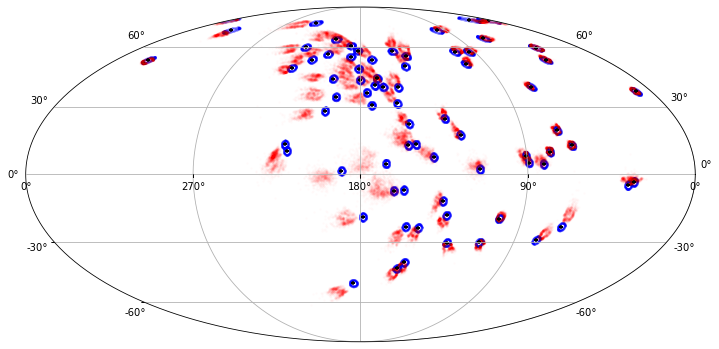

In [37]:
skymap = AllSkyMap(lon_0=180)
skymap.ax.grid()

skymap.scatter(
        np.rad2deg(omega_rand[:, :, 0]),
        np.rad2deg(omega_rand[:, :, 1]),
        color="b",
        alpha=0.02,
        s=5.0,
        lw=0,
    )
skymap.scatter(
        np.rad2deg(omega_gal[:, :, 0]),
        np.rad2deg(omega_gal[:, :, 1]),
        color='r',#rgba_color,
        alpha=0.02,
        # c=rgba_color,
        s=5.0,
        lw=0,
    )
skymap.scatter(
        np.rad2deg(omega_true[:, 0]),
        np.rad2deg(omega_true[:, 1]),
        color="k",
        alpha=1,
        marker="+",
        s=20.0,
    )